<a href="https://colab.research.google.com/github/chihyanghsu0805/machine_learning/blob/tutorials/tutorials/keras/graph_representation_learning/node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Install packages

In [1]:
pip install networkx

In [2]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip",
    "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

# Exploratory Data Analysis

In [4]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

print(f"Movies data shape: {movies.shape}")
print(f"Ratings data shape: {ratings.shape}")

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [5]:
# Rows are movies, columns are [Id, title, genres]
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# rows are ratings, columns are [User, Movie, rating, timestamp]
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe813a46a50>]],
      dtype=object)

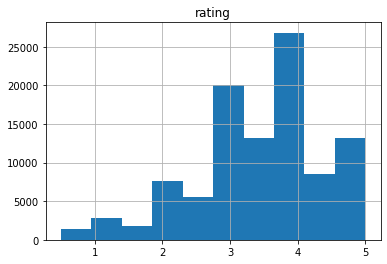

In [7]:
# Rating range from 0 to 5 with 0.5 as step size
ratings.hist("rating")

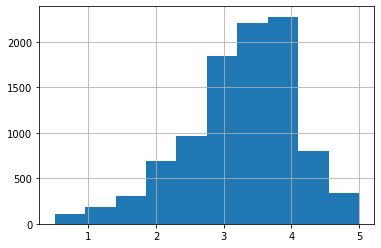

In [8]:
# Average ratings by movie
ratings.groupby("movieId")["rating"].mean().hist()

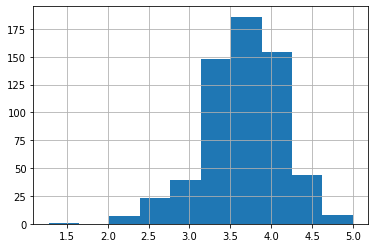

In [9]:
# Average ratings by user
ratings.groupby("userId")["rating"].mean().hist()

In [ ]:
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")


# Data Preprocessing
We create an edge between two movie nodes in the graph if both movies are rated
by the same user >= `min_rating`. The weight of the edge will be based on the
[pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information)
between the two movies, which is computed as: `log(xy) - log(x) - log(y) + log(D)`, where:

* `xy` is how many users rated both movie `x` and movie `y` with >= `min_rating`.
* `x` is how many users rated movie `x` >= `min_rating`.
* `y` is how many users rated movie `y` >= `min_rating`.
* `D` total number of movie ratings >= `min_rating`.

## Step 1: Create the edges between movies rated by the same user with minimum rating

In [10]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

rated_movies = ratings[ratings.rating >= min_rating]
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in movies_grouped_by_users:
        
    current_movies = list(group[1]["movieId"]) # group[0] is index
        
    for i in range(len(current_movies)):

        item_frequency[current_movies[i]] += 1

        for j in range(i + 1, len(current_movies)):
            
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

In [11]:
min_weight = 10 # How many users have the same rating
D = math.log(sum(item_frequency.values()))

movies_graph = nx.Graph()

for pair in pair_frequency:

    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

In [12]:
print(f"Total number of graph nodes: {movies_graph.number_of_nodes()}")
print(f"Total number of graph edges: {movies_graph.number_of_edges()}")

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [13]:
degrees = [movies_graph.degree[n] for n in movies_graph.nodes]
print(f"Average node degree: {round(sum(degrees) / len(degrees), 2)}")

Average node degree: 57.0


### Step 3: Create vocabulary and a mapping from tokens to integer indices

In [14]:
vocabulary = ["NA"] + list(movies_graph.nodes) # movieId starts with 1
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [15]:
print(vocabulary_lookup)

{'NA': 0, 47: 1, 50: 2, 151: 3, 163: 4, 216: 5, 231: 6, 260: 7, 333: 8, 457: 9, 527: 10, 596: 11, 608: 12, 1029: 13, 1073: 14, 1080: 15, 1089: 16, 1136: 17, 1196: 18, 1197: 19, 1198: 20, 1206: 21, 1210: 22, 1213: 23, 1220: 24, 1222: 25, 1240: 26, 1270: 27, 1275: 28, 1278: 29, 1291: 30, 1517: 31, 1573: 32, 1617: 33, 1625: 34, 1732: 35, 2005: 36, 2094: 37, 2115: 38, 2116: 39, 2329: 40, 2387: 41, 2459: 42, 2470: 43, 2502: 44, 2529: 45, 2542: 46, 2571: 47, 2700: 48, 2716: 49, 2858: 50, 2949: 51, 2959: 52, 2987: 53, 3033: 54, 3052: 55, 3147: 56, 3253: 57, 3386: 58, 3441: 59, 3578: 60, 3671: 61, 3703: 62, 101: 63, 362: 64, 553: 65, 923: 66, 1097: 67, 1282: 68, 1587: 69, 1954: 70, 2058: 71, 2078: 72, 2395: 73, 2580: 74, 2692: 75, 2761: 76, 2944: 77, 2948: 78, 3034: 79, 3448: 80, 3450: 81, 3793: 82, 919: 83, 954: 84, 2427: 85, 2991: 86, 5060: 87, 2872: 88, 661: 89, 2947: 90, 3702: 91, 940: 92, 1031: 93, 1256: 94, 2018: 95, 2141: 96, 2161: 97, 2353: 98, 1049: 99, 1023: 100, 3053: 101, 1927: 102

## Implement the biased random walk

A random walk starts from a given node, and randomly picks a neighbour node to move to.
If the edges are weighted, the neighbour is selected *probabilistically* with
respect to weights of the edges between the current node and its neighbours.
This procedure is repeated for `num_steps` to generate a sequence of *related* nodes.

The [*biased* random walk](https://en.wikipedia.org/wiki/Biased_random_walk_on_a_graph) balances between **breadth-first sampling**
(where only local neighbours are visited) and **depth-first sampling**
(where  distant neighbours are visited) by introducing the following two parameters:

1. **Return parameter** (`p`): Controls the likelihood of immediately revisiting
a node in the walk. Setting it to a high value encourages moderate exploration,
while setting it to a low value would keep the walk local.
2. **In-out parameter** (`q`): Allows the search to differentiate
between *inward* and *outward* nodes. Setting it to a high value biases the
random walk towards local nodes, while setting it to a low value biases the walk
to visit nodes which are further away.

In [16]:
def next_step(graph, previous, current, p, q):

    neighbors = list(graph.neighbors(current))
    weights = []

    for neighbor in neighbors:
        
        if neighbor == previous:            
            weights.append(graph[current][neighbor]["weight"] / p)

        elif graph.has_edge(neighbor, previous):            
            weights.append(graph[current][neighbor]["weight"])

        else:
            weights.append(graph[current][neighbor]["weight"] / q)
    
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next

In [17]:
def random_walk(graph, num_walks, num_steps, p, q):
    
    walks = []
    nodes = list(graph.nodes())
    
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in nodes:
            
            walk = [node]
            
            while len(walk) < num_steps:

                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(graph, previous, current, p, q)
                walk.append(next)

            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)

    return walks

## Generate training data using the biased random walk

You can explore different configurations of `p` and `q` to different results of
related movies.

In [18]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print(f"Number of walks generated: {len(walks)}")

Number of walks generated: 7025


## Generate positive and negative examples

To train a skip-gram model, we use the generated walks to create positive and
negative training examples. Each example includes the following features:

1. `target`: A movie in a walk sequence.
2. `context`: Another movie in a walk sequence.
3. `weight`: How many times these two movies occured in walk sequences.
4. `label`: The label is 1 if these two movies are samples from the walk sequences,
otherwise (i.e., if randomly sampled) the label is 0.

### Generate examples

In [21]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in sequences:
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)

In [22]:
num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:24<00:00, 291.05it/s]


Let's display the shapes of the outputs

In [23]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (883457,)
Contexts shape: (883457,)
Labels shape: (883457,)
Weights shape: (883457,)


### Convert the data into `tf.data.Dataset` objects

In [24]:
def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [25]:
batch_size = 1024

dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

## Train the skip-gram model

Our skip-gram is a simple binary classification model that works as follows:

1. An embedding is looked up for the `target` movie.
2. An embedding is looked up for the `context` movie.
3. The dot product is computed between these two embeddings.
4. The result (after a sigmoid activation) is compared to the label.
5. A binary crossentropy loss is used.

In [26]:
learning_rate = 0.001
embedding_dim = 32
num_epochs = 10

### Implement the model

In [27]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Train the model

We instantiate the model and compile it.

In [28]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

Let's plot the model.

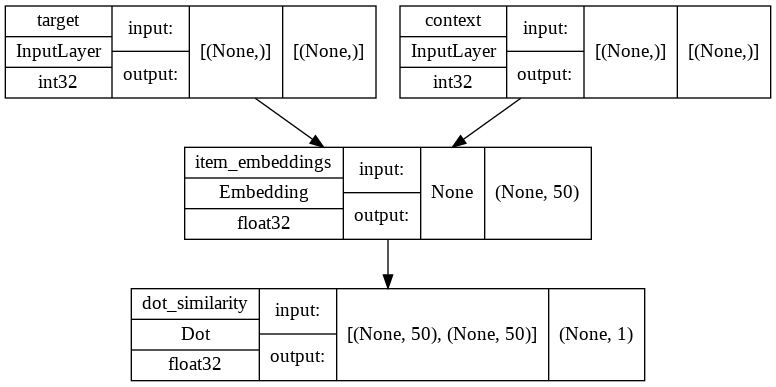

In [29]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

Now we train the model on the `dataset`.

In [30]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
862/862 [==============================] - 8s 9ms/step - loss: 2.4471
Epoch 2/10
862/862 [==============================] - 6s 7ms/step - loss: 2.3388
Epoch 3/10
862/862 [==============================] - 7s 8ms/step - loss: 2.3320
Epoch 4/10
862/862 [==============================] - 6s 7ms/step - loss: 2.3284
Epoch 5/10
862/862 [==============================] - 14s 16ms/step - loss: 2.3246
Epoch 6/10
862/862 [==============================] - 6s 7ms/step - loss: 2.3204
Epoch 7/10
862/862 [==============================] - 6s 7ms/step - loss: 2.3167
Epoch 8/10
862/862 [==============================] - 6s 7ms/step - loss: 2.3135
Epoch 9/10
862/862 [==============================] - 11s 13ms/step - loss: 2.3107
Epoch 10/10
862/862 [==============================] - 6s 7ms/step - loss: 2.3082


Finally we plot the learning history.

## Analyze the learnt embeddings.

In [39]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print(f"Embeddings shape: {movie_embeddings.shape}")

Embeddings shape: (1406, 50)


### Find related movies

Define a list with some movies called `query_movies`.

In [33]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [34]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

In [35]:
def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

Get the embeddings of the movies in `query_movies`.

In [36]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

# Compute the cosine similarity between the embeddings of queries and other movies, then pick the top k

In [40]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=10)
indices = indices.numpy().tolist()

In [46]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(query_embeddings),
    transpose_b=True,
)

print(similarities)

tf.Tensor(
[[0.16354087 0.1686353  0.12940064 0.1530269  0.15858021]
 [0.1686353  0.2093599  0.14222485 0.18167162 0.18458462]
 [0.12940064 0.14222485 0.24716975 0.15566635 0.10802281]
 [0.1530269  0.18167162 0.15566635 0.18781543 0.16694582]
 [0.15858021 0.18458462 0.10802281 0.16694582 0.19211411]], shape=(5, 5), dtype=float32)


Display the top related movies in `query_movies`.

In [44]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}, {similarities[idx][token]:0.2f}")
    print()

Matrix, The (1999)
------------------
- Pulp Fiction (1994), 0.01
- Lord of the Rings: The Fellowship of the Ring, The (2001), 0.01
- Inception (2010), 0.01
- Star Wars: Episode IV - A New Hope (1977), 0.01
- Fight Club (1999), 0.01
- Star Wars: Episode V - The Empire Strikes Back (1980), 0.01
- Matrix, The (1999), 0.01
- Lord of the Rings: The Return of the King, The (2003), 0.01
- Dark Knight, The (2008), 0.01
- American Beauty (1999), 0.01

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977), 0.02
- Pulp Fiction (1994), 0.02
- Princess Bride, The (1987), 0.02
- Star Wars: Episode V - The Empire Strikes Back (1980), 0.02
- Usual Suspects, The (1995), 0.02
- Lord of the Rings: The Fellowship of the Ring, The (2001), 0.02
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), 0.02
- American Beauty (1999), 0.02
- Saving Private Ryan (1998), 0.02
- Braveheart (1995), 0.02

Lion King, T

### Visualize the embeddings using the Embedding Projector

In [ ]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()

Download the `embeddings.tsv` and `metadata.tsv` to analyze the obtained embeddings
in the [Embedding Projector](https://projector.tensorflow.org/).